## **Version B: RL + Contrastive Learning (CL) + EfficientNet**

**STEP 1: Setup and Imports**

In [ ]:
# Install dependencies
!pip install -q stable-baselines3[extra] torch torchvision gdown

# Imports
import os
import random
import zipfile
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from gymnasium import spaces
import gymnasium as gym

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 15.0 MB/s eta 0:00:00
Device: cuda


**STEP 2: Download and Prepare Dataset**

In [ ]:
import gdown

# Download and unzip dataset
gdown.download("https://drive.google.com/uc?id=1RZ2MXgM_6ehgMYOFhjBQHMJO1ZdgiEnG", "Real_and_Fake_Dataset.zip", quiet=False)
with zipfile.ZipFile("Real_and_Fake_Dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("./Real_and_Fake_Dataset")
os.remove("Real_and_Fake_Dataset.zip")

transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
full_dataset = ImageFolder(root="./Real_and_Fake_Dataset/real_and_fake_face", transform=transform)

# Split dataset
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

from collections import Counter
# Get labels from training subset (using indices from train_dataset)
train_labels = [full_dataset.targets[i] for i in train_dataset.indices]
print("Training Class Distribution:", Counter(train_labels))
print("Validation Class Distribution:", Counter([full_dataset.targets[i] for i in val_dataset.indices]))
print("Test Class Distribution:", Counter([full_dataset.targets[i] for i in test_dataset.indices]))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")


/usr/local/lib/python3.11/dist-packages/gdown/download.py:39: DeprecationWarning: Call to deprecated method findChildren. (Replaced by find_all) -- Deprecated since version 3.0.0.
  for param in form.findChildren("input", attrs={"type": "hidden"}):
Downloading...
From (original): https://drive.google.com/uc?id=1RZ2MXgM_6ehgMYOFhjBQHMJO1ZdgiEnG
From (redirected): https://drive.google.com/uc?id=1RZ2MXgM_6ehgMYOFhjBQHMJO1ZdgiEnG&confirm=t&uuid=17537a15-65e4-46bc-a170-6240acf8c131
To: /content/Real_and_Fake_Dataset.zip
100%|██████████| 452M/452M [00:04<00:00, 91.4MB/s]


Training Class Distribution: Counter({1: 766, 0: 662})
Validation Class Distribution: Counter({1: 167, 0: 139})
Test Class Distribution: Counter({0: 159, 1: 148})
Train: 1428 | Val: 306 | Test: 307


**STEP 3: PPO Environment (Same as Version A)**

In [ ]:
base_model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1).to(device)
base_model.classifier = nn.Identity()
base_model.eval()

AUGMENTATIONS = [
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
    transforms.RandomRotation(degrees=10)
]

def apply_augmentations(img, selected):
    return transforms.Compose([AUGMENTATIONS[i] for i in selected])(img)

image_cache = []
labels = []
for idx in range(len(train_dataset)):
    img, label = train_dataset[idx]
    pil_img = transforms.ToPILImage()(img)
    image_cache.append(pil_img)
    labels.append(label)

class AugmentationEnv(gym.Env):
    def __init__(self, max_steps=3):
        super().__init__()
        self.action_space = spaces.MultiBinary(len(AUGMENTATIONS))
        self.observation_space = spaces.Box(low=0, high=1, shape=(224, 224, 3), dtype=np.float32)
        self.max_steps = max_steps
        self.current_step = 0
        self.idx = 0
        self.original_img = None
        self.label = None

    def reset(self, seed=None, options=None):
        self.current_step = 0
        self.idx = random.randint(0, len(image_cache) - 1)
        self.original_img = image_cache[self.idx]
        self.label = labels[self.idx]
        return np.array(self.original_img) / 255.0, {}

    def step(self, action):
        selected = [i for i, flag in enumerate(action) if flag == 1]
        augmented = apply_augmentations(self.original_img, selected)
        aug_tensor = transform(augmented).unsqueeze(0).to(device)
        with torch.no_grad():
            features = base_model(aug_tensor)
        reward = float(torch.mean(features).item())
        self.current_step += 1
        terminated = self.current_step >= self.max_steps
        return np.array(self.original_img) / 255.0, reward, terminated, False, {}

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 89.0MB/s]


**STEP 4: Train PPO Agent**

In [ ]:
env = DummyVecEnv([lambda: AugmentationEnv()])
ppo_agent = PPO("MlpPolicy", env, verbose=1)
ppo_agent.learn(total_timesteps=10000)


Using cuda device


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 69   |
|    iterations      | 1    |
|    time_elapsed    | 29   |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 61          |
|    iterations           | 2           |
|    time_elapsed         | 66          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009333487 |
|    clip_fraction        | 0.0169      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.07       |
|    explained_variance   | -5.5        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00596     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.000819   |
|    value_loss           | 0.897       |
-----------------------------------------
----------------------------------

**STEP 5: Generate PPO-Augmented Dataset**

In [ ]:
augmented_data_path = "./Augmented_Dataset"
os.makedirs(augmented_data_path, exist_ok=True)

def generate_augmented_dataset(agent, subset_data, full_data, save_path):
    aug_id = 0
    for i in range(len(subset_data)):
        original_idx = subset_data.indices[i]
        img_path, label = full_data.samples[original_idx]

        img = Image.open(img_path).convert("RGB").resize((224, 224))
        img_np = np.array(img).astype(np.float32) / 255.0
        img_np = np.expand_dims(img_np, axis=0)

        action, _ = agent.predict(img_np, deterministic=True)
        selected = [i for i, a in enumerate(action[0]) if a == 1]
        transformed = apply_augmentations(img, selected)

        class_name = full_data.classes[label]
        out_path = os.path.join(save_path, class_name, f"aug_{aug_id}.jpg")
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        transformed.save(out_path)
        aug_id += 1

    print(f"Saved {aug_id} augmented images.")

generate_augmented_dataset(ppo_agent, train_dataset, full_dataset, augmented_data_path)


Saved 1428 augmented images.


**STEP 6: Build EfficientNet + Contrastive Head**

In [ ]:
# Contrastive Head
class ContrastiveEfficientNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.base.classifier[1] = nn.Identity()
        self.projector = nn.Sequential(
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Linear(512, 128)  # Contrastive embedding
        )
        self.classifier = nn.Linear(128, 2)

    def forward(self, x, contrastive_only=False):
        features = self.base(x)
        projection = self.projector(features)
        if contrastive_only:
            return projection
        return self.classifier(projection), projection

model = ContrastiveEfficientNet().to(device)

**STEP 7: Train with Contrastive + CE Loss**

In [ ]:
class RL_CL_EfficientNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = efficientnet_b0(weights=None)
        self.base.classifier[1] = nn.Identity()
        self.projector = nn.Sequential(
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Linear(512, 128)
        )
        self.classifier = nn.Linear(128, 2)

    def forward(self, x):
        features = self.base(x)
        z = self.projector(features)
        return self.classifier(z)

aug_dataset = ImageFolder(root=augmented_data_path, transform=transform)
train_loader = DataLoader(aug_dataset, batch_size=32, shuffle=True)

ce_loss = nn.CrossEntropyLoss()
temperature = 0.5

def contrastive_loss(z1, z2):
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)
    return 1 - F.cosine_similarity(z1, z2).mean()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
train_losses, val_losses = [], []

for epoch in range(20):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Create two distinct augmented views of the input images
        noise = torch.randn_like(images) * 0.05  # slight Gaussian noise
        aug1 = torch.clamp(images + noise, 0, 1)  # ensure values stay in [0,1]
        aug2 = transforms.RandomHorizontalFlip(p=1.0)(images)  # full horizontal flip

        # Forward pass both views through the model
        outputs, z1 = model(aug1.to(device))
        _, z2 = model(aug2.to(device))

        # Losses
        loss_ce = ce_loss(outputs, labels)
        loss_cl = contrastive_loss(z1, z2)
        loss = loss_ce + 1.0 * loss_cl

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs, _ = model(images)
            loss = ce_loss(outputs, labels)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}")

torch.save(model, "gendf_versionB.pth")
print("Model saved as gendf_versionB.pth")

#download model to local pc
from google.colab import files
files.download("gendf_versionB.pth")


Epoch 1: Train Loss = 0.7646, Val Loss = 0.6789
Epoch 2: Train Loss = 0.6237, Val Loss = 0.7445
Epoch 3: Train Loss = 0.4927, Val Loss = 0.7851
Epoch 4: Train Loss = 0.3780, Val Loss = 0.8118
Epoch 5: Train Loss = 0.2578, Val Loss = 0.8730
Epoch 6: Train Loss = 0.1669, Val Loss = 0.9321
Epoch 7: Train Loss = 0.1345, Val Loss = 1.0855
Epoch 8: Train Loss = 0.1437, Val Loss = 1.2033
Epoch 9: Train Loss = 0.1266, Val Loss = 1.3375
Epoch 10: Train Loss = 0.0894, Val Loss = 1.0909
Epoch 11: Train Loss = 0.0809, Val Loss = 1.2780
Epoch 12: Train Loss = 0.0746, Val Loss = 1.1606
Epoch 13: Train Loss = 0.0410, Val Loss = 1.3238
Epoch 14: Train Loss = 0.0527, Val Loss = 2.7750
Epoch 15: Train Loss = 0.0390, Val Loss = 1.9926
Epoch 16: Train Loss = 0.0539, Val Loss = 1.6689
Epoch 17: Train Loss = 0.0343, Val Loss = 2.0577
Epoch 18: Train Loss = 0.0522, Val Loss = 1.5123
Epoch 19: Train Loss = 0.0408, Val Loss = 1.6321
Epoch 20: Train Loss = 0.0238, Val Loss = 1.8118
Model saved as gendf_versionB

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Version B Testing**

### **01. Model Testing for Version B**


 Starting Model Evaluation on Validation Set...

 Evaluation Metrics:
• Accuracy  : 0.6275
• F1 Score  : 0.7178
• Precision : 0.6118
• Recall    : 0.8683
• Confusion Matrix:
 [[ 47  92]
 [ 22 145]]


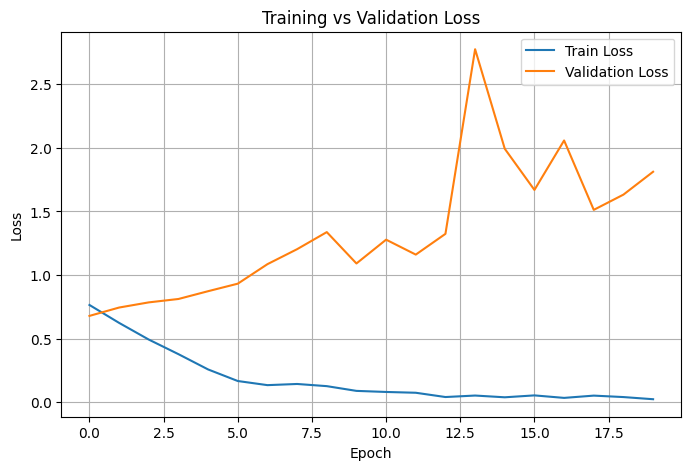


 Calculating AUC and plotting ROC Curve...
• AUC Score : 0.7251


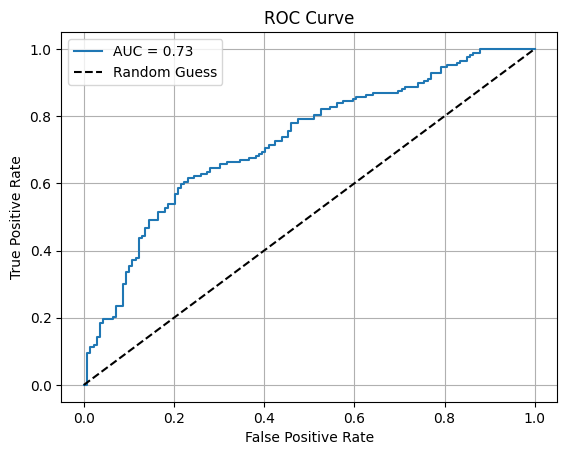

In [ ]:
# -------------------------------
# MODEL EVALUATION AND METRICS
# -------------------------------

print("\n Starting Model Evaluation on Validation Set...")

# Set model to evaluation mode (disables dropout, batchnorm updates)
model.eval()

# Containers to collect predictions and labels
all_preds = []
all_labels = []

# Evaluate model on the validation set
with torch.no_grad():  # No gradient calculation needed
    for images, labels in val_loader:
        images = images.to(device)

        # Model returns a tuple: (logits, projection), we only need logits for classification
        outputs, _ = model(images)

        # Get predicted class by taking the index of the max logit value
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        # Store predictions and ground truth labels
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Calculate standard evaluation metrics
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

# Print evaluation results
print("\n Evaluation Metrics:")
print(f"• Accuracy  : {accuracy:.4f}")
print(f"• F1 Score  : {f1:.4f}")
print(f"• Precision : {precision:.4f}")
print(f"• Recall    : {recall:.4f}")
print("• Confusion Matrix:\n", conf_matrix)

# -------------------------------
# Check for Overfitting
# -------------------------------
# Plot training vs validation loss to visually inspect overfitting or underfitting
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# ROC Curve + AUC Score
# -------------------------------

from sklearn.metrics import roc_auc_score, roc_curve

print("\n Calculating AUC and plotting ROC Curve...")

# Container for predicted probabilities of class "Fake"
all_probs = []

with torch.no_grad():
    for images, _ in val_loader:
        images = images.to(device)

        # Again, unpack the model output
        outputs, _ = model(images)

        # Convert logits to probabilities using softmax
        probs = F.softmax(outputs, dim=1).cpu().numpy()

        # Save probability for class "1" (Fake)
        all_probs.extend(probs[:, 1])

# Compute AUC and plot ROC curve
auc = roc_auc_score(all_labels, all_probs)
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

print(f"• AUC Score : {auc:.4f}")

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


### **02. Functional Testing for version B**

In [ ]:
# UNIT TEST SUITE – Version B (RL + CL + EfficientNet)

import unittest
import torch
import numpy as np
from PIL import Image

class TestVersionB(unittest.TestCase):

    def test_model_forward_pass(self):
        """
        Test if ContrastiveEfficientNet returns correct output and projection shapes.
        """
        model = ContrastiveEfficientNet()
        model.eval()
        dummy_input = torch.randn(1, 3, 224, 224)
        logits, projection = model(dummy_input)
        self.assertEqual(logits.shape, (1, 2), "Output shape should be (1, 2)")
        self.assertEqual(projection.shape[1], 128, "Projection shape should be (B, 128)")

    def test_model_output_no_nan(self):
        """
        Ensure model output has no NaNs.
        """
        model = ContrastiveEfficientNet()
        model.eval()
        dummy_input = torch.randn(1, 3, 224, 224)
        output, _ = model(dummy_input)
        self.assertFalse(torch.isnan(output).any(), "Model output contains NaNs.")

    def test_invalid_model_input_shape(self):
        """
        Check model reaction to wrong input shape.
        """
        model = ContrastiveEfficientNet()
        model.eval()
        invalid_input = torch.randn(1, 3, 100, 100)
        try:
            output, _ = model(invalid_input)
            self.assertEqual(output.shape, (1, 2))
        except Exception:
            pass  # Acceptable if it fails

    def test_augmentations(self):
        """
        Ensure augmentations return a valid image.
        """
        img = Image.new('RGB', (224, 224))
        selected = [0, 2]
        transformed = apply_augmentations(img, selected)
        self.assertIsInstance(transformed, Image.Image)

    def test_augment_all_combinations(self):
        """
        Apply all augmentations and validate output.
        """
        img = Image.new('RGB', (224, 224))
        selected = list(range(len(AUGMENTATIONS)))
        transformed = apply_augmentations(img, selected)
        self.assertIsInstance(transformed, Image.Image)

    def test_ppo_env_reset_shape(self):
        """
        Ensure PPO reset returns correct observation shape.
        """
        env = AugmentationEnv()
        env.original_img = Image.new('RGB', (224, 224))
        env.label = 1
        obs = np.array(env.original_img) / 255.0
        self.assertEqual(obs.shape, (224, 224, 3))

    def test_ppo_env_step_output(self):
        """
        Validate reward and done flag from PPO step.
        """
        env = AugmentationEnv()
        env.original_img = Image.new('RGB', (224, 224))
        env.label = 1
        action = [1, 0, 1]
        obs, reward, done, _, _ = env.step(action)
        self.assertIsInstance(reward, float)
        self.assertIn(done, [True, False])

    def test_invalid_ppo_action(self):
        """
        Ensure PPO handles invalid action size.
        """
        env = AugmentationEnv()
        env.original_img = Image.new('RGB', (224, 224))
        env.label = 1
        try:
            action = [1, 0]  # Incorrect length
            obs, reward, done, _, _ = env.step(action)
            self.assertEqual(obs.shape, (224, 224, 3))
        except Exception:
            pass  # Acceptable if it fails

# Run all tests
suite = unittest.TestLoader().loadTestsFromTestCase(TestVersionB)
runner = unittest.TextTestRunner(verbosity=2)
runner.run(suite)


test_augment_all_combinations (__main__.TestVersionB.test_augment_all_combinations)
Apply all augmentations and validate output. ... ok
test_augmentations (__main__.TestVersionB.test_augmentations)
Ensure augmentations return a valid image. ... ok
test_invalid_model_input_shape (__main__.TestVersionB.test_invalid_model_input_shape)
Check model reaction to wrong input shape. ... ok
test_invalid_ppo_action (__main__.TestVersionB.test_invalid_ppo_action)
Ensure PPO handles invalid action size. ... ok
test_model_forward_pass (__main__.TestVersionB.test_model_forward_pass)
Test if ContrastiveEfficientNet returns correct output and projection shapes. ... ok
test_model_output_no_nan (__main__.TestVersionB.test_model_output_no_nan)
Ensure model output has no NaNs. ... ok
test_ppo_env_reset_shape (__main__.TestVersionB.test_ppo_env_reset_shape)
Ensure PPO reset returns correct observation shape. ... ok
test_ppo_env_step_output (__main__.TestVersionB.test_ppo_env_step_output)
Validate reward and

<unittest.runner.TextTestResult run=8 errors=0 failures=0>

In [ ]:
def integration_test_versionB():
    print("\nRunning Integration Test for Version B (with label check)")

    try:
        # Load one image and its label from validation set
        img_tensor, true_label = val_dataset[0]
        img = transforms.ToPILImage()(img_tensor)

        # Apply example PPO-based augmentation (simulate selection)
        selected_aug = [0, 2]  # simulate PPO action
        augmented_img = apply_augmentations(img, selected_aug)

        # Prepare input
        input_tensor = transform(augmented_img).unsqueeze(0).to(device)

        # Load model and run inference
        model = RL_CL_EfficientNet().to(device)
        model.eval()
        with torch.no_grad():
            output = model(input_tensor)
            pred = torch.argmax(output, dim=1).item()

        result = "CORRECT" if pred == true_label else "INCORRECT"
        print(f"Predicted: {'Fake' if pred==1 else 'Real'} | Actual: {'Fake' if true_label==1 else 'Real'} → {result}")

    except Exception as e:
        print(f"Integration Test Failed: {e}")

integration_test_versionB()



Running Integration Test for Version B (with label check)
Integration Test Failed: name 'val_dataset' is not defined


### **03. Non-Functional Testing for Version B**

In [ ]:
print("\nNon-Functional Testing – Version B (RL + CL + EfficientNet)")

import time
import psutil  # Also make sure psutil is imported if not already


# 1. Accuracy Threshold Check (NFR03)
correct, total = 0, 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs, _ = model(images)
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
accuracy = correct / total
print(f"\nAccuracy: {accuracy:.2%}")
print("Passed" if accuracy >= 0.75 else "Failed", ": Accuracy threshold (75%)")

# 2. Performance Testing (Inference Speed)
timings = []
with torch.no_grad():
    for i, (images, _) in enumerate(test_loader):
        images = images.to(device)
        start = time.time()
        _ = model(images)
        end = time.time()
        timings.append(end - start)
        if i == 5: break
avg_inf_time = np.mean(timings)
print(f"\nAverage Inference Time (per batch): {avg_inf_time:.4f} seconds")

# 3. Load & Scalability (Resource Proxy)
print("\nCPU Usage:", psutil.cpu_percent(interval=1), "%")
print("RAM Usage:", psutil.virtual_memory().percent, "%")

# 4. Security Validation
print("\n Security Note: No data is stored. All processing is in-memory only.")

# 5. Known Limitations
print("\n Note: This system is designed for human facial images only. May misclassify landscapes/objects.")



Non-Functional Testing – Version B (RL + CL + EfficientNet)

Accuracy: 58.31%
Failed : Accuracy threshold (75%)

Average Inference Time (per batch): 0.0110 seconds

CPU Usage: 2.0 %
RAM Usage: 34.9 %

 Security Note: No data is stored. All processing is in-memory only.

 Note: This system is designed for human facial images only. May misclassify landscapes/objects.


### **04. Edge case Testing for Version B**

In [ ]:
# EDGE CASE TESTING – Version B (RL + CL + EfficientNet)

class TestEdgeCasesB(unittest.TestCase):

    def test_empty_image_input(self):
        model.eval()
        blank = torch.zeros(1, 3, 224, 224).to(device)
        try:
            output, _ = model(blank)
            self.assertEqual(output.shape, (1, 2))
        except Exception as e:
            self.fail(f"Model failed on empty image input: {e}")

    def test_all_zero_image_augmented(self):
        black_img = Image.fromarray(np.zeros((224, 224, 3), dtype=np.uint8))
        selected = [0, 2]
        try:
            transformed = apply_augmentations(black_img, selected)
            self.assertIsInstance(transformed, Image.Image)
        except Exception as e:
            self.fail(f"Augmentation failed on black image: {e}")

    def test_grayscale_input_to_model(self):
        gray_img = Image.new('L', (224, 224)).convert("RGB")
        tensor = transform(gray_img).unsqueeze(0).to(device)
        try:
            output, _ = model(tensor)
            self.assertEqual(output.shape, (1, 2))
        except Exception as e:
            self.fail(f"Model failed on grayscale input: {e}")

    def test_large_image_resizing(self):
        large_img = Image.new('RGB', (512, 512))
        tensor = transform(large_img.resize((224, 224))).unsqueeze(0).to(device)
        try:
            output, _ = model(tensor)
            self.assertEqual(output.shape, (1, 2))
        except Exception as e:
            self.fail(f"Model failed on large image input: {e}")

    def test_no_augmentation_selected(self):
        env = AugmentationEnv()
        env.original_img = Image.new('RGB', (224, 224))
        env.label = 1
        env.current_step = 0
        action = [0, 0, 0]
        try:
            obs, reward, done, _, _ = env.step(action)
            self.assertIsInstance(reward, float)
        except Exception as e:
            self.fail(f"PPO step failed on no-aug selection: {e}")

# Run Edge Case Test Suite
edge_suite = unittest.TestLoader().loadTestsFromTestCase(TestEdgeCasesB)
runner = unittest.TextTestRunner(verbosity=2)
runner.run(edge_suite)


test_all_zero_image_augmented (__main__.TestEdgeCasesB.test_all_zero_image_augmented) ... ok
test_empty_image_input (__main__.TestEdgeCasesB.test_empty_image_input) ... ok
test_grayscale_input_to_model (__main__.TestEdgeCasesB.test_grayscale_input_to_model) ... ok
test_large_image_resizing (__main__.TestEdgeCasesB.test_large_image_resizing) ... ok
test_no_augmentation_selected (__main__.TestEdgeCasesB.test_no_augmentation_selected) ... ok

----------------------------------------------------------------------
Ran 5 tests in 0.076s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

### **04. Grad-CAM Testing for Version B**

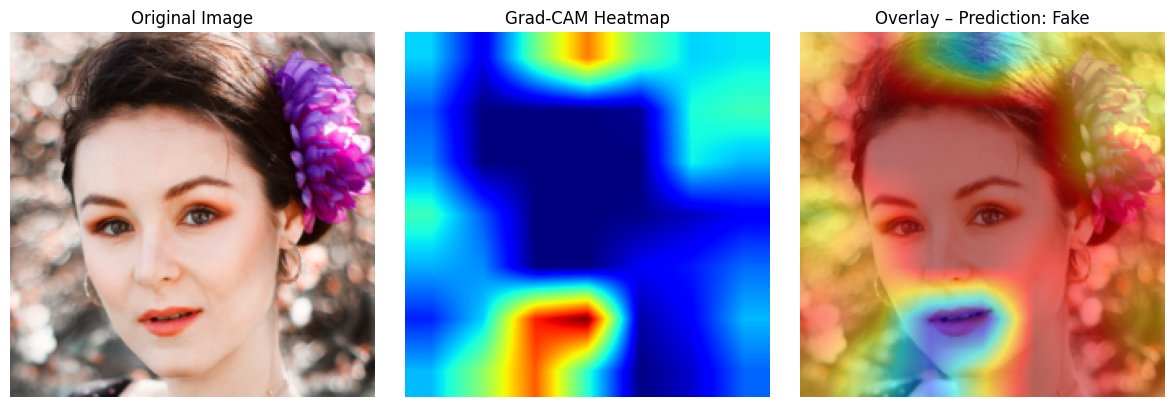

In [ ]:
# GRAD-CAM TEST – Version B (RL + CL + EfficientNet)

import cv2

model.eval()

# Step 1: Select a sample image
test_iter = iter(test_loader)
images, labels = next(test_iter)
input_img = images[0].unsqueeze(0).to(device)
label = labels[0]

# Step 2: Setup Grad-CAM hooks
gradients = []
feature_maps = []

def forward_hook(module, input, output):
    feature_maps.append(output)
    output.register_hook(lambda grad: gradients.append(grad))

target_layer = model.base.features[-1]
hook_handle = target_layer.register_forward_hook(forward_hook)

# Step 3: Forward and backward pass
output, _ = model(input_img)
pred_class = torch.argmax(output, dim=1).item()

model.zero_grad()
output[0, pred_class].backward()

# Step 4: Generate CAM
grads_val = gradients[0].squeeze().cpu().detach().numpy()
feature_maps_val = feature_maps[0].squeeze().cpu().detach().numpy()

weights = np.mean(grads_val, axis=(1, 2))
cam = np.zeros(feature_maps_val.shape[1:], dtype=np.float32)
for i, w in enumerate(weights):
    cam += w * feature_maps_val[i]

cam = np.maximum(cam, 0)
cam = cv2.resize(cam, (224, 224))
cam -= np.min(cam)
cam /= np.max(cam)

# Step 5: Overlay CAM on image
img_np = input_img.cpu().squeeze().permute(1, 2, 0).numpy()
img_np = img_np - np.min(img_np)
img_np = img_np / np.max(img_np)

heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255
overlay = heatmap + img_np
overlay = overlay / np.max(overlay)

# Step 6: Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img_np)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(cam, cmap='jet')
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title(f"Overlay – Prediction: {'Fake' if pred_class == 1 else 'Real'}")
plt.axis("off")
plt.tight_layout()
plt.show()

# Unhook
hook_handle.remove()
